## A 4k MMR Dota 2 Player and Data Scientist's Predictive Model

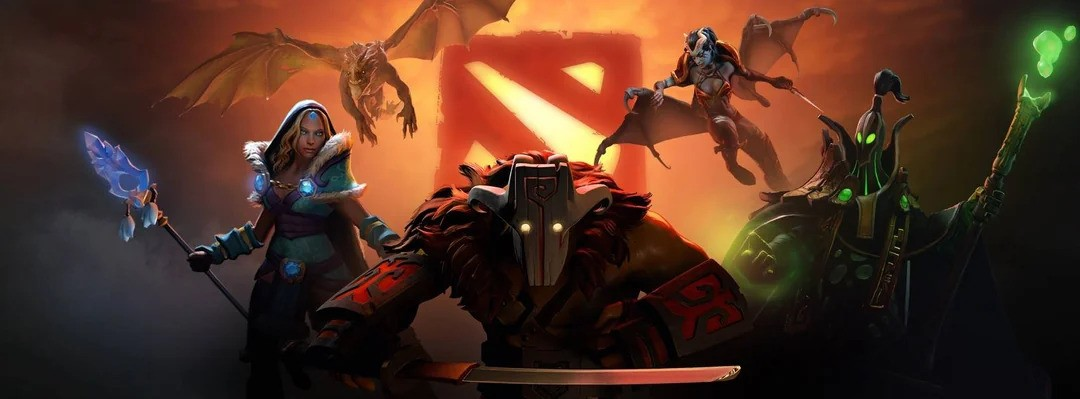

This is the notebook of a 4k MMR DotA 2 player's approach to predicting whether the Radiant or Dire side will win the game. As a longtime fan of Dota with over 1.5k hours in the mid lane maining Shadow Fiend, Invoker, and Pudge, I was pleasantly surprised by mlcourse.ai's new Kaggle Competition. This notebook serves as an introduction to both the game of Dota 2 and binary classification.

### Libraries

We'll begin by loading in an assortment of libraries to help us on the data science end-to-end pipeline.

In [1]:
import ujson as json

In [2]:
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.model_selection import train_test_split # to split
from sklearn.model_selection import TimeSeriesSplit # to split
from sklearn.metrics import roc_curve # ROC curve
from sklearn.metrics import roc_auc_score # ROC score
from sklearn.model_selection import cross_val_score # cross validation score
from sklearn.feature_extraction.text import CountVectorizer # CountVectorizer
from sklearn.preprocessing import StandardScaler # standartization
from sklearn.preprocessing import MinMaxScaler # standartization
from sklearn.model_selection import GridSearchCV # to find best parameters
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting
from sklearn.ensemble import BaggingClassifier # bagging
from sklearn.ensemble import VotingClassifier # ensemble models (voting and mean)
from sklearn.metrics import confusion_matrix # Confusion Matrix
from sklearn.svm import SVC # SVM
from sklearn.svm import LinearSVC # SVM
from sklearn.pipeline import make_pipeline # pipeline
from catboost import CatBoostClassifier, Pool # Yandex Gradient Boosting
import xgboost as xgb # Gradient Boosting
from mlxtend.classifier import StackingClassifier # stacking
from mlxtend.classifier import StackingCVClassifier # stacking
import lightgbm as lgb # Microsoft Gradien Boosting
import matplotlib.pyplot as plt # to plot
plt.style.use('ggplot')
import seaborn as sns # to plot
import numpy as np # to count
import pandas as pd # DataFrames
from scipy import stats # stats
import pickle # reading pckle files
from IPython.display import display # Display tables
import time # time checking
import re # regex
import eli5 # feature importance
from collections import Counter # to count
pd.set_option('display.max_columns', None) # to display max columns in DataFrames
pd.options.mode.chained_assignment = None  # turn off mistakes

Additionally, we'll add in some **helper** functions for writing our results to the submission file.

In [3]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [4]:
train = pd.read_csv('/kaggle/input/mlcourse-dota2-win-prediction/train_features.csv', index_col='match_id_hash')
target = pd.read_csv('/kaggle/input/mlcourse-dota2-win-prediction/train_targets.csv', index_col='match_id_hash')
test = pd.read_csv('/kaggle/input/mlcourse-dota2-win-prediction/test_features.csv', index_col='match_id_hash')

### Understanding the Data

Let's use .head(), .describe(), to analyze the data.


In [5]:
train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,543,7,533,358,600,350.93784,2,116,122,0.000000,0,0,1,0,0.000000,0,0,0,0,78,0,0,0,3,399,4,478,636,720,254.93774,2,124,126,0.000000,0,0,0,0,0.000000,0,0,0,0,14,0,1,0,0,304,0,130,700,700,242.93773,1,70,156,0.000000,0,0,1,0,0.000000,0,0,0,0,59,0,0,0,1,389,4,506,399,700,326.93780,2,170,86,0.000000,0,0,0,0,0.000000,0,0,0,0,77,0,0,0,0,402,10,344,422,800,314.93780,2,120,100,0.000000,0,0,0,0,0.000000,0,0,0,0,12,0,0,1,13,982,12,780,650,720,386.93787,3,82,170,0.000000,0,0,1,0,1.00,0,0,0,0,21,0,0,0,6,788,9,706,640,640,422.93790,3,174,90,0.000000,0,0,2,0,0.00,0,0,0,0,60,0,0,0,1,531,0,307,720,720,242.93773,2,180,84,0.299948,0,0,2,0,0.00,0,0,0,0,84,1,0,0

In [6]:
train.describe()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
count,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000

#### Data Balancing
Let's look at our binary values that we are predicting and make sure that it is fairly balanced. Here, we are trying to predict whether the Radiant or Dire side wins so we check counts for 'radiant_win'.

In [7]:
target['radiant_win'].value_counts()

radiant_win
True     20826
False    18849
Name: count, dtype: int64

We need to now construct a feature matrix X and also build our target vector y to perform our train/test split. We will keep it a simple random forest classifier model.

In [8]:
X = train.values
y = target['radiant_win'].values

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=17)

Training the model here, the n_estimators is the number of trees in the forest. The more trees we have, the better the data learning process is but also the slower the training is. On the other side, n_jobs tells our engine how many processors to use. We use 4 in this case.

In [10]:
%%time

model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17)
model.fit(X_train, y_train)

CPU times: user 35 s, sys: 107 ms, total: 35.1 s
Wall time: 9.56 s


RandomForestClassifier(n_jobs=4, random_state=17)

We can then make predictive probabilities of class 1 - that our Radiant team wins and then evaluate how well 

In [11]:
y_pred = model.predict_proba(X_valid)[:, 1]

In [12]:
y_pred

array([0.14, 0.44, 0.5 , ..., 0.58, 0.72, 0.51])

In [13]:
valid_score = roc_auc_score(y_valid, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.7772318342722802
